# NB01: Module Conservation Profiles

Are ICA fitness modules enriched in core or accessory genes?

Merges module membership data from `fitness_modules` with conservation
status from `conservation_vs_fitness`. 29 organisms overlap between projects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import os

MODULE_DIR = Path('../../fitness_modules/data/modules')
FAMILY_DIR = Path('../../fitness_modules/data/module_families')
CONS_DIR = Path('../../conservation_vs_fitness/data')
DATA_DIR = Path('../data')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load conservation link table
link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
link = link[link['orgId'] != 'Dyella79']

# Find overlapping organisms
mod_orgs = set(f.replace('_gene_membership.csv', '')
               for f in os.listdir(MODULE_DIR) if f.endswith('_gene_membership.csv'))
link_orgs = set(link['orgId'].unique())
overlap_orgs = sorted(mod_orgs & link_orgs)

print(f'Module organisms: {len(mod_orgs)}')
print(f'Link table organisms: {len(link_orgs)}')
print(f'Overlap: {len(overlap_orgs)}')

Module organisms: 32
Link table organisms: 43
Overlap: 29


## Step 1: Build Gene-Level Dataset

In [2]:
# For each organism, melt module membership and join with conservation
all_module_genes = []

for orgId in overlap_orgs:
    mem = pd.read_csv(MODULE_DIR / f'{orgId}_gene_membership.csv')
    # Melt: one row per gene x module where membership = 1
    module_cols = [c for c in mem.columns if c.startswith('M')]
    melted = mem.melt(id_vars='locusId', value_vars=module_cols,
                      var_name='module', value_name='member')
    melted = melted[melted['member'] == 1].drop(columns='member')
    melted['orgId'] = orgId
    all_module_genes.append(melted)

module_genes = pd.concat(all_module_genes, ignore_index=True)
print(f'Module gene assignments: {len(module_genes):,} (gene x module pairs)')
print(f'Unique genes in modules: {module_genes.drop_duplicates(["orgId","locusId"]).shape[0]:,}')

# Join with conservation
module_genes['locusId'] = module_genes['locusId'].astype(str)
link['locusId'] = link['locusId'].astype(str)

mg = module_genes.merge(
    link[['orgId', 'locusId', 'is_core', 'is_auxiliary', 'is_singleton', 'gene_cluster_id']],
    on=['orgId', 'locusId'], how='left'
)
mg['is_mapped'] = mg['gene_cluster_id'].notna()
mg['conservation'] = 'unmapped'
mg.loc[mg['is_mapped'] & (mg['is_core'] == True), 'conservation'] = 'core'
mg.loc[mg['is_mapped'] & (mg['is_singleton'] == True), 'conservation'] = 'singleton'
mg.loc[mg['is_mapped'] & (mg['is_core'] != True) & (mg['is_singleton'] != True), 'conservation'] = 'auxiliary'

print(f'\nModule genes with conservation status:')
print(mg['conservation'].value_counts().to_string())

Module gene assignments: 30,897 (gene x module pairs)
Unique genes in modules: 27,670

Module genes with conservation status:
conservation
core         23099
unmapped      4213
auxiliary     2434
singleton     1151


## Step 2: Per-Module Conservation Composition

In [3]:
# Per-module conservation composition
module_cons = mg.groupby(['orgId', 'module']).agg(
    n_genes=('locusId', 'size'),
    n_mapped=('is_mapped', 'sum'),
    n_core=('is_core', lambda x: (x == True).sum()),
    n_auxiliary=('is_auxiliary', lambda x: (x == True).sum()),
    n_singleton=('is_singleton', lambda x: (x == True).sum()),
).reset_index()

module_cons['pct_core'] = (module_cons['n_core'] / module_cons['n_mapped'] * 100).round(1)
module_cons['pct_core'] = module_cons['pct_core'].fillna(0)

# Organism baseline % core (all genes, not just module genes)
org_baseline = link.groupby('orgId')['is_core'].mean().reset_index()
org_baseline.columns = ['orgId', 'baseline_core_frac']
org_baseline['baseline_pct_core'] = (org_baseline['baseline_core_frac'] * 100).round(1)

module_cons = module_cons.merge(org_baseline, on='orgId', how='left')

print(f'Modules analyzed: {len(module_cons):,}')
print(f'\nModule % core summary:')
print(f'  Mean: {module_cons["pct_core"].mean():.1f}%')
print(f'  Median: {module_cons["pct_core"].median():.1f}%')
print(f'  Baseline mean: {module_cons["baseline_pct_core"].mean():.1f}%')

# Are module genes more core than non-module genes?
module_unique = mg.drop_duplicates(['orgId', 'locusId'])
in_module_core = (module_unique[module_unique['is_mapped']]['is_core'] == True).mean() * 100

all_genes_core = (link['is_core'] == True).mean() * 100

print(f'\n=== MODULE GENES vs ALL GENES ===')
print(f'  Module genes % core: {in_module_core:.1f}%')
print(f'  All genes % core:    {all_genes_core:.1f}%')
print(f'  Difference: {in_module_core - all_genes_core:+.1f} percentage points')

# Save
module_cons.to_csv(DATA_DIR / 'module_conservation.tsv', sep='\t', index=False)

Modules analyzed: 1,008

Module % core summary:
  Mean: 85.1%
  Median: 93.4%
  Baseline mean: 82.2%

=== MODULE GENES vs ALL GENES ===
  Module genes % core: 86.0%
  All genes % core:    81.5%
  Difference: +4.5 percentage points


## Step 3: Module Conservation Spectrum

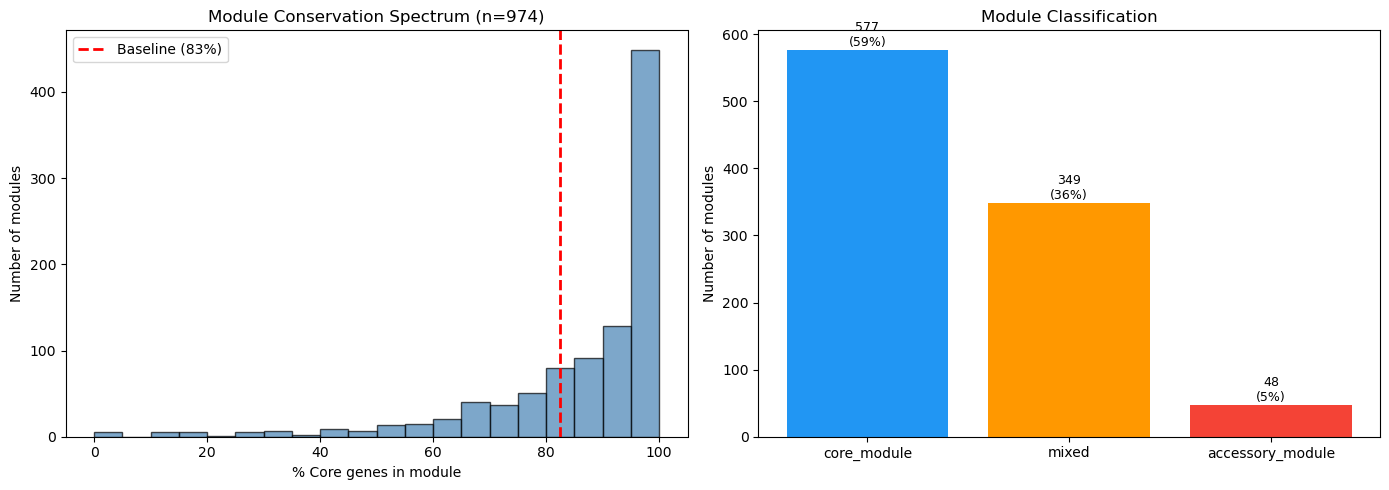

=== MODULE CLASSIFICATION ===
module_type
core_module         577
mixed               349
accessory_module     48


In [4]:
# Only modules with mapped genes
has_mapped = module_cons[module_cons['n_mapped'] >= 3]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of % core
axes[0].hist(has_mapped['pct_core'], bins=20, range=(0, 100),
             edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=has_mapped['baseline_pct_core'].mean(), color='red',
                linestyle='--', linewidth=2, label=f'Baseline ({has_mapped["baseline_pct_core"].mean():.0f}%)')
axes[0].set_xlabel('% Core genes in module')
axes[0].set_ylabel('Number of modules')
axes[0].set_title(f'Module Conservation Spectrum (n={len(has_mapped)})')
axes[0].legend()

# Classify modules
has_mapped = has_mapped.copy()
has_mapped['module_type'] = 'mixed'
has_mapped.loc[has_mapped['pct_core'] >= 90, 'module_type'] = 'core_module'
has_mapped.loc[has_mapped['pct_core'] < 50, 'module_type'] = 'accessory_module'

type_counts = has_mapped['module_type'].value_counts()
axes[1].bar(range(len(type_counts)), type_counts.values,
            color=['#2196F3', '#FF9800', '#F44336'])
axes[1].set_xticks(range(len(type_counts)))
axes[1].set_xticklabels(type_counts.index)
axes[1].set_ylabel('Number of modules')
axes[1].set_title('Module Classification')

for i, (cat, n) in enumerate(type_counts.items()):
    axes[1].text(i, n + 5, f'{n}\n({n/len(has_mapped)*100:.0f}%)', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'module_core_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('=== MODULE CLASSIFICATION ===')
print(type_counts.to_string())

## Step 4: Module Function vs Conservation

In [5]:
# Load module annotations
all_annot = []
for orgId in overlap_orgs:
    annot_file = MODULE_DIR / f'{orgId}_module_annotations.csv'
    if annot_file.exists():
        ann = pd.read_csv(annot_file)
        ann['orgId'] = orgId
        all_annot.append(ann)

if all_annot:
    annotations = pd.concat(all_annot, ignore_index=True)
    print(f'Module annotations loaded: {len(annotations):,} rows')
    print(f'Columns: {annotations.columns.tolist()}')
    
    # Get the best annotation per module (lowest FDR)
    if 'fdr' in annotations.columns:
        best_annot = annotations.sort_values('fdr').drop_duplicates(['orgId', 'module'], keep='first')
    elif 'p_value' in annotations.columns:
        best_annot = annotations.sort_values('p_value').drop_duplicates(['orgId', 'module'], keep='first')
    else:
        best_annot = annotations.drop_duplicates(['orgId', 'module'], keep='first')
    
    # Merge with module conservation
    mc_annot = has_mapped.merge(best_annot, on=['orgId', 'module'], how='left')
    
    # Group by annotation database
    if 'db' in mc_annot.columns:
        db_col = 'db'
    elif 'database' in mc_annot.columns:
        db_col = 'database'
    else:
        db_col = None
    
    if db_col:
        print(f'\nAnnotation databases:')
        print(mc_annot[db_col].value_counts().to_string())
    
    # Get the annotation term
    term_col = 'term' if 'term' in mc_annot.columns else 'annotation' if 'annotation' in mc_annot.columns else None
    
    if term_col:
        annotated = mc_annot[mc_annot[term_col].notna()]
        print(f'\nAnnotated modules: {len(annotated)} / {len(mc_annot)}')
        
        # Top terms in core modules vs accessory modules
        core_mods = annotated[annotated['module_type'] == 'core_module']
        acc_mods = annotated[annotated['module_type'] == 'accessory_module']
        
        print(f'\n=== TOP ANNOTATIONS IN CORE MODULES (n={len(core_mods)}) ===')
        if len(core_mods) > 0:
            print(core_mods[term_col].value_counts().head(15).to_string())
        
        print(f'\n=== TOP ANNOTATIONS IN ACCESSORY MODULES (n={len(acc_mods)}) ===')
        if len(acc_mods) > 0:
            print(acc_mods[term_col].value_counts().head(15).to_string())
else:
    print('No module annotation files found')

Module annotations loaded: 5,995 rows
Columns: ['term', 'n_overlap', 'n_module', 'n_term', 'odds_ratio', 'p_value', 'module', 'database', 'fdr', 'significant', 'orgId']

Annotation databases:
database
PFam       549
SEED       127
KEGG        67
TIGRFam     60

Annotated modules: 803 / 974

=== TOP ANNOTATIONS IN CORE MODULES (n=477) ===
term
PF02653      11
PF00528      10
PF01012       8
PF00270       7
PF00460       7
PF00994       6
PF00072       6
PF00590       6
PF00361       6
PF02518       5
PF03471       5
TIGR01726     5
PF00155       4
PF05138       4
PF00271       4

=== TOP ANNOTATIONS IN ACCESSORY MODULES (n=37) ===
term
PF13692                                     2
PF00122                                     2
TIGR01539                                   2
PF00589                                     1
PF13443                                     1
TIGR04057                                   1
K03657                                      1
PF02668                            

In [6]:
print('=' * 60)
print('NB01 SUMMARY: Module Conservation Profiles')
print('=' * 60)
print(f'Organisms: {len(overlap_orgs)}')
print(f'Module gene pairs: {len(module_genes):,}')
print(f'Modules analyzed: {len(has_mapped)}')
print(f'Module genes % core: {in_module_core:.1f}%')
print(f'All genes % core: {all_genes_core:.1f}%')
print(f'Module types: {dict(type_counts)}')
print('=' * 60)

NB01 SUMMARY: Module Conservation Profiles
Organisms: 29
Module gene pairs: 30,897
Modules analyzed: 974
Module genes % core: 86.0%
All genes % core: 81.5%
Module types: {'core_module': np.int64(577), 'mixed': np.int64(349), 'accessory_module': np.int64(48)}
